In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy
import librosa
import tqdm
import copy
import glob
import time

import models
import datasets
import oracles
import metrics
import utils
import change_point_detection as cpd
import query_strategies as qs
import evaluate
import visualize

import metrics

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

(4, 5, 10, 99)


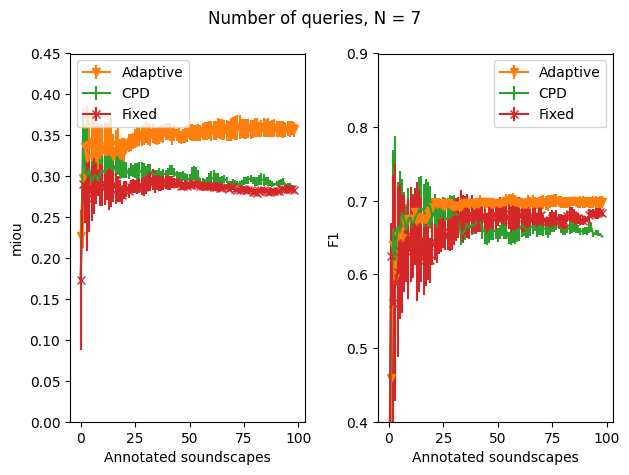

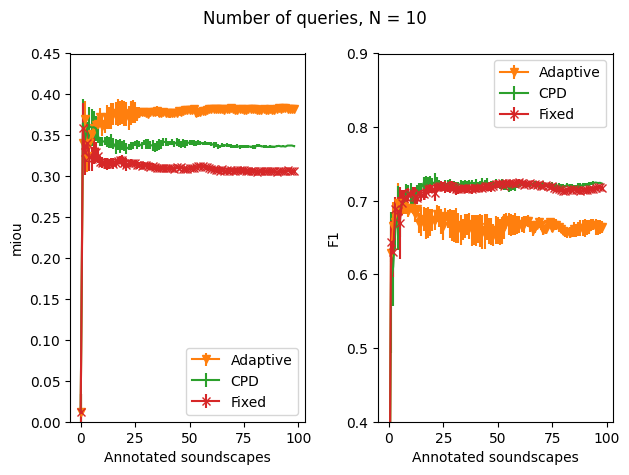

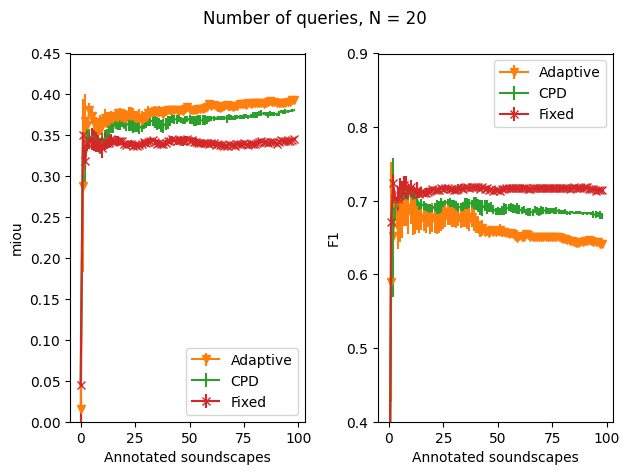

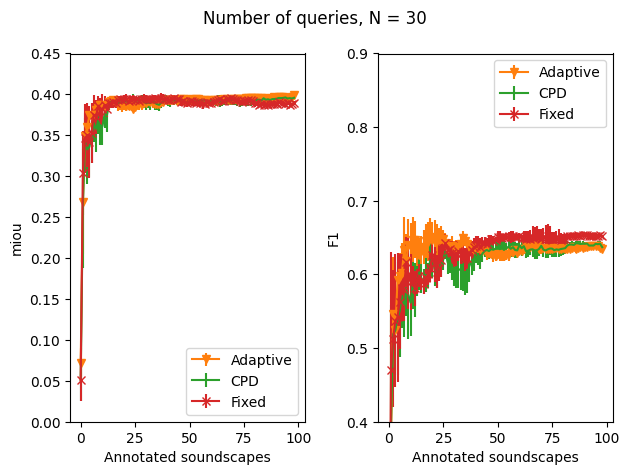

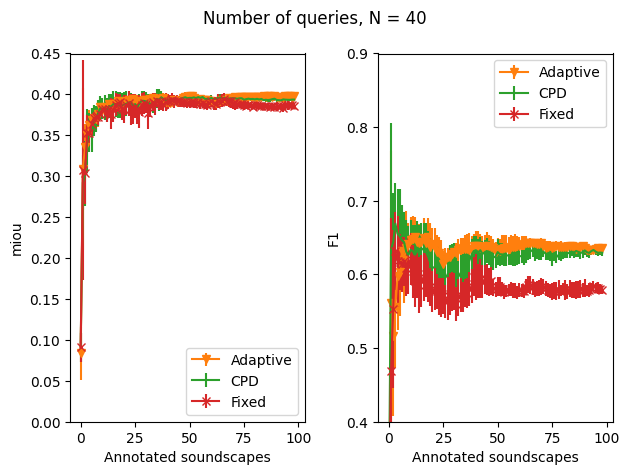

In [25]:
# cpd_miou_scores_test = np.load('../results/0.8s_0.25s_cpd_baseline_full/miou_scores_test.npy')
# cpd_f1_scores_test   = np.load('../results/0.8s_0.25s_cpd_baseline_full/f1_scores_test.npy')

# miou_scores_test = np.load('../results/0.8s_0.25s_random_init/miou_scores_test.npy')
# f1_scores_test   = np.load('../results/0.8s_0.25s_random_init/f1_scores_test.npy')

miou_scores_test = np.load('../results/10_30/0.8s_0.20s_final/miou_scores_test.npy')
f1_scores_test   = np.load('../results/10_30/0.8s_0.20s_final/f1_scores_test.npy')

print(miou_scores_test.shape)

#n_queriess = [7, 10, 20, 30, 40] #7, 10, 20, 30, 40, 50] #, 30] #5,7,10,20,30]
n_queriess = [7, 10, 20, 30, 40]

#n_queriess = [0.25, 0.5, 1.0, 2.0] # TODO: NOISE FACTOR

strategy_names = ['Active and adaptive', 'Adaptive', 'CPD', 'Fixed']
markers = [None, 'v', None, 'x']

for idx_n_queries in range(len(n_queriess)):
    fig, ax = plt.subplots(1, 2)
    for idx_strategy in [1, 2, 3]: #[0, 1, 2, 3]: #range(4):
        if idx_strategy == 2:
            tmp_f1 = f1_scores_test #cpd_f1_scores_test
            tmp_miou = miou_scores_test #cpd_miou_scores_test
        else:
            tmp_f1 = f1_scores_test
            tmp_miou = miou_scores_test
        
        mean_mious = tmp_miou[idx_strategy, idx_n_queries].mean(axis=0)
        std_mious  = tmp_miou[idx_strategy, idx_n_queries].std(axis=0)
        
        mean_f1s   = tmp_f1[idx_strategy, idx_n_queries].mean(axis=0)
        std_f1s    = tmp_f1[idx_strategy, idx_n_queries].std(axis=0)
        
        N = miou_scores_test.shape[3]
        ax[0].errorbar(x=np.arange(N), y=mean_mious, yerr=std_mious, label=strategy_names[idx_strategy], color=colors[idx_strategy], marker=markers[idx_strategy])
        ax[0].set_xlabel('Annotated soundscapes')
        ax[0].set_ylabel('miou')
        ax[0].legend()
        ax[0].set_ylim([0.0, 0.45])
        
        ax[1].errorbar(x=np.arange(N), y=mean_f1s, yerr=std_f1s, label=strategy_names[idx_strategy], color=colors[idx_strategy], marker=markers[idx_strategy])
        ax[1].set_xlabel('Annotated soundscapes')
        ax[1].set_ylabel('F1')
        ax[1].legend()
        ax[1].set_ylim([0.4, 0.9])
        
        plt.suptitle('Number of queries, N = {}'.format(n_queriess[idx_n_queries]))
    
    plt.tight_layout()

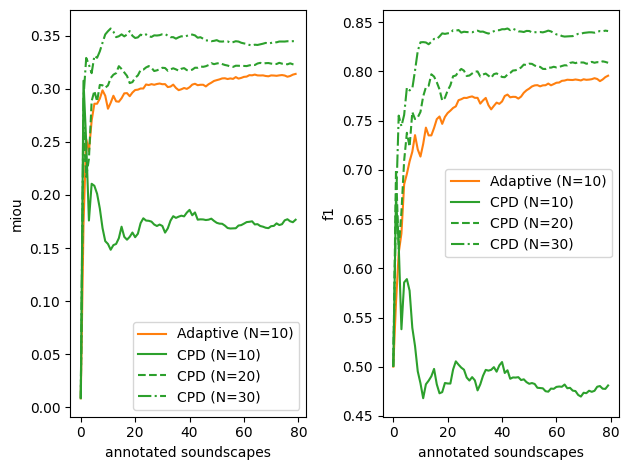

In [92]:
miou_scores_test = np.load('../results/0.8s_0.25s_random_init/miou_scores_test.npy')
f1_scores_test   = np.load('../results/0.8s_0.25s_random_init/f1_scores_test.npy')

cpd_miou_scores_test = np.load('../results/0.8s_0.25s_cpd_baseline_full/miou_scores_test.npy')
cpd_f1_scores_test   = np.load('../results/0.8s_0.25s_cpd_baseline_full/f1_scores_test.npy')

mean_mious_cpd_10 = cpd_miou_scores_test[2, 1].mean(axis=0)
mean_f1s_cpd_10 = cpd_f1_scores_test[2, 1].mean(axis=0)

mean_mious_cpd_20 = cpd_miou_scores_test[2, 2].mean(axis=0)
mean_f1s_cpd_20 = cpd_f1_scores_test[2, 2].mean(axis=0)

mean_mious_cpd_30 = cpd_miou_scores_test[2, 3].mean(axis=0)
mean_f1s_cpd_30 = cpd_f1_scores_test[2, 3].mean(axis=0)

mean_mious_ad_10 = miou_scores_test[1, 1].mean(axis=0)
mean_f1s_ad_10   = f1_scores_test[1, 1].mean(axis=0)

# mean_mious_ad_20 = miou_scores_test[1, 2].mean(axis=0)
# mean_f1s_ad_20   = f1_scores_test[1, 2].mean(axis=0)

mean_mious_fix_10 = miou_scores_test[3, 1].mean(axis=0)
mean_f1s_fix_10   = f1_scores_test[3, 1].mean(axis=0)

mean_mious_fix_20 = miou_scores_test[3, 2].mean(axis=0)
mean_f1s_fix_20   = f1_scores_test[3, 2].mean(axis=0)

mean_mious_fix_30 = miou_scores_test[3, 3].mean(axis=0)
mean_f1s_fix_30   = f1_scores_test[3, 3].mean(axis=0)

mean_mious_fix_40 = miou_scores_test[3, 4].mean(axis=0)
mean_f1s_fix_40   = f1_scores_test[3, 4].mean(axis=0)



fig, ax = plt.subplots(1, 2)

ax[0].plot(mean_mious_ad_10, color=colors[1], label    ='Adaptive (N=10)')

ax[0].plot(mean_mious_cpd_10, color=colors[2], label    ='CPD (N=10)')
ax[0].plot(mean_mious_cpd_20, color=colors[2], linestyle='dashed', label    ='CPD (N=20)')
ax[0].plot(mean_mious_cpd_30, color=colors[2], linestyle='dashdot', label    ='CPD (N=30)')

#ax[0].plot(mean_mious_ad_20, color='green', linestyle='dashed', label    ='Adaptive (N=20)')
# ax[0].plot(mean_mious_fix_10, color=colors[3], label='Fixed       (N=10)')
# ax[0].plot(mean_mious_fix_20, color=colors[3], linestyle='dashed', label='Fixed       (N=20)')
# ax[0].plot(mean_mious_fix_30, color=colors[3], linestyle='dashdot', label='Fixed       (N=30)')
# ax[0].plot(mean_mious_fix_40, color=colors[3], linestyle='dotted', label   ='Fixed       (N=40)')


ax[0].set_xlabel('annotated soundscapes')
ax[0].set_ylabel('miou')
ax[0].legend()
#ax[0].set_ylim([0.2, 0.4])

ax[1].plot(mean_f1s_ad_10, color=colors[1], label    ='Adaptive (N=10)')
#ax[1].plot(mean_f1s_ad_20, color='green', linestyle='dashed', label    ='Adaptive (N=20)')

ax[1].plot(mean_f1s_cpd_10, color=colors[2], label    ='CPD (N=10)')
ax[1].plot(mean_f1s_cpd_20, color=colors[2], linestyle='dashed', label    ='CPD (N=20)')
ax[1].plot(mean_f1s_cpd_30, color=colors[2], linestyle='dashdot', label    ='CPD (N=30)')

# ax[1].plot(mean_f1s_fix_10, color=colors[3], label ='Fixed       (N=10)')
# ax[1].plot(mean_f1s_fix_20, color=colors[3], linestyle='dashed', label='Fixed       (N=20)')
# ax[1].plot(mean_f1s_fix_30, color=colors[3], linestyle='dashdot', label='Fixed       (N=30)')
# ax[1].plot(mean_f1s_fix_40, color=colors[3], linestyle='dotted', label   ='Fixed       (N=40)')


ax[1].set_xlabel('annotated soundscapes')
ax[1].set_ylabel('f1')
ax[1].legend()
plt.tight_layout()
#ax[1].set_ylim([0.5, 0.9])

----------------------------
N = 7
----------------------------
strategy = ADP, n_queries = 07, f1 = 0.945 +/- 0.097, miou = 0.146 +/- 0.037
strategy = CPD, n_queries = 07, f1 = 0.927 +/- 0.111, miou = 0.099 +/- 0.045
strategy = FIX, n_queries = 07, f1 = 0.858 +/- 0.131, miou = 0.034 +/- 0.005
----------------------------
N = 10
----------------------------
strategy = ADP, n_queries = 10, f1 = 0.938 +/- 0.108, miou = 0.154 +/- 0.035
strategy = CPD, n_queries = 10, f1 = 0.940 +/- 0.107, miou = 0.124 +/- 0.047
strategy = FIX, n_queries = 10, f1 = 0.891 +/- 0.131, miou = 0.048 +/- 0.009
----------------------------
N = 20
----------------------------
strategy = ADP, n_queries = 20, f1 = 0.947 +/- 0.095, miou = 0.163 +/- 0.031
strategy = CPD, n_queries = 20, f1 = 0.959 +/- 0.090, miou = 0.157 +/- 0.037
strategy = FIX, n_queries = 20, f1 = 0.889 +/- 0.132, miou = 0.094 +/- 0.020
----------------------------
N = 30
----------------------------
strategy = ADP, n_queries = 30, f1 = 0.940 +/- 0

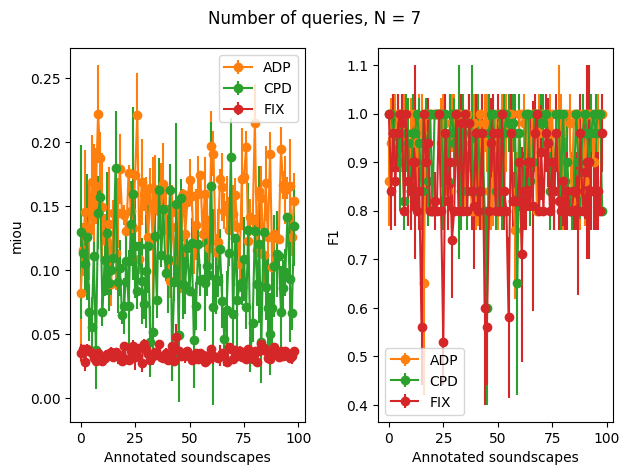

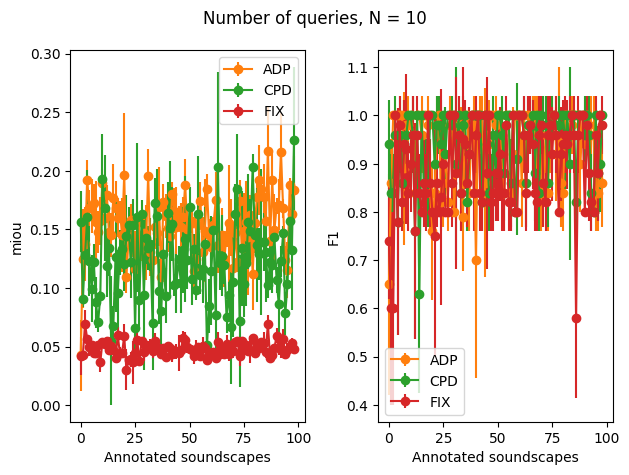

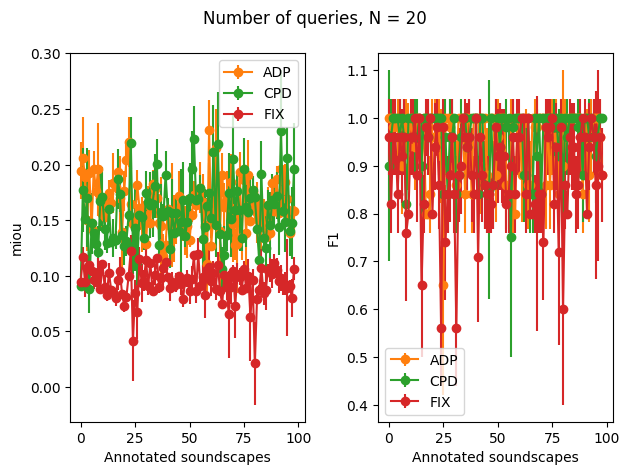

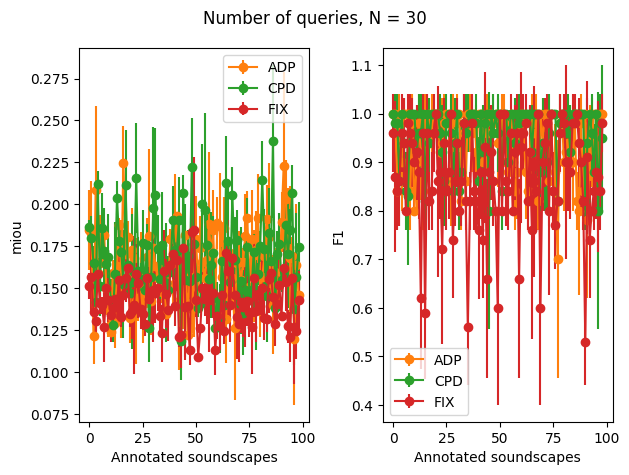

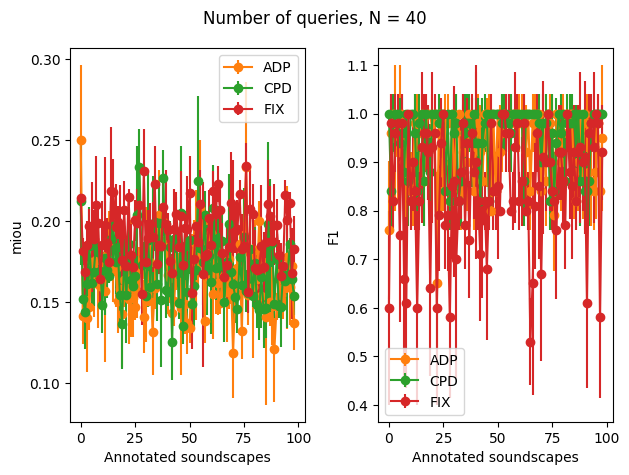

In [26]:
#cpd_miou_scores_train = np.load('../results/0.8s_0.25s_cpd_baseline_full/miou_scores_train.npy')
#cpd_f1_scores_train   = np.load('../results/0.8s_0.25s_cpd_baseline_full/f1_scores_train.npy')

miou_scores_train = np.load('../results/10_30/0.8s_0.20s_final/miou_scores_train.npy')
f1_scores_train   = np.load('../results/10_30/0.8s_0.20s_final/f1_scores_train.npy')

#n_queriess = [7, 10, 20, 30, 40] #, 30] #5,7,10,20,30]
n_queriess = [7, 10, 20, 30, 40]

strategy_names = ['Active and adaptive', 'ADP', 'CPD', 'FIX']

for idx_n_queries in range(len(n_queriess)):
    print("----------------------------")
    print("N = {}".format(n_queriess[idx_n_queries]))
    print("----------------------------")
    fig, ax = plt.subplots(1, 2)
    for idx_strategy in [1, 2, 3]: #[0, 1, 2, 3]: #range(4):

        if idx_strategy == 2:
            tmp_f1 = f1_scores_train # cpd_f1_scores_train
            tmp_miou = miou_scores_train #cpd_miou_scores_train
        else:
            tmp_f1 = f1_scores_train
            tmp_miou = miou_scores_train
        
        mean_mious = tmp_miou[idx_strategy, idx_n_queries].mean(axis=0)
        std_mious  = tmp_miou[idx_strategy, idx_n_queries].std(axis=0)

        total_mean_mious = tmp_miou[idx_strategy, idx_n_queries].mean(axis=(0, 1))
        total_std_mious  = tmp_miou[idx_strategy, idx_n_queries].std(axis=(0, 1))
        
        mean_f1s   = tmp_f1[idx_strategy, idx_n_queries].mean(axis=0)
        std_f1s    = tmp_f1[idx_strategy, idx_n_queries].std(axis=0)

        total_mean_f1s = tmp_f1[idx_strategy, idx_n_queries].mean(axis=(0, 1)) 
        total_std_f1s = tmp_f1[idx_strategy, idx_n_queries].std(axis=(0, 1))
        
        # label quality of training data
        mean_mious_train = miou_scores_train[idx_strategy, idx_n_queries].mean(axis=0)
        mean_f1s_train   = f1_scores_train[idx_strategy, idx_n_queries].mean(axis=0)

        N = miou_scores_train.shape[3]
        #N = 10
        ax[0].errorbar(x=np.arange(N), y=mean_mious[:N], yerr=std_mious[:N], label=strategy_names[idx_strategy], color=colors[idx_strategy], marker='o')
        #ax[0].plot(mean_mious_train, label=strategy_names[idx_strategy] + ' (train)', color=colors[idx_strategy], linestyle='dashed')
        ax[0].set_xlabel('Annotated soundscapes')
        ax[0].set_ylabel('miou')
        ax[0].legend()
        #ax[0].set_ylim([0.0, 0.4])
        
        ax[1].errorbar(x=np.arange(N), y=mean_f1s[:N], yerr=std_f1s[:N], label=strategy_names[idx_strategy], color=colors[idx_strategy], marker='o')
        #ax[1].plot(mean_f1s_train, label=strategy_names[idx_strategy] + ' (train)', color=colors[idx_strategy], linestyle='dashed')
        ax[1].set_xlabel('Annotated soundscapes')
        ax[1].set_ylabel('F1')
        ax[1].legend()
        #ax[1].set_ylim([0.4, 0.9])

        print("strategy = {}, n_queries = {:02d}, f1 = {:.3f} +/- {:.3f}, miou = {:.3f} +/- {:.3f}".format(strategy_names[idx_strategy], n_queriess[idx_n_queries], total_mean_f1s, total_std_f1s, total_mean_mious, total_std_mious))
        
        plt.suptitle('Number of queries, N = {}'.format(n_queriess[idx_n_queries]))
    
    plt.tight_layout()

In [95]:
x, y, yerr = rand(3, 10)
plt.
errorbar(x, y, yerr, marker='s', mfc='red',
         mec='green', ms=20, mew=4)

NameError: name 'rand' is not defined

(0.5, 0.9)

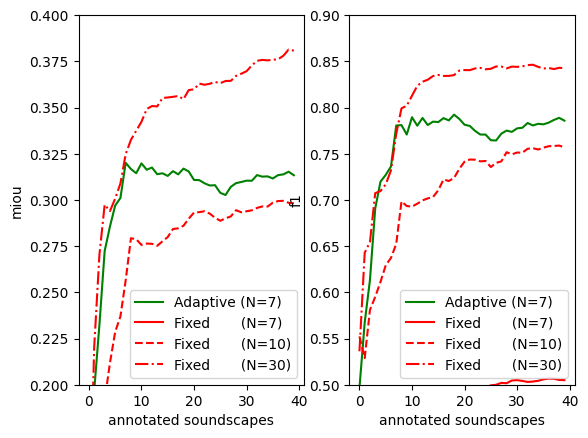

In [118]:
mean_mious_ad = miou_scores_test[1, 1].mean(axis=0)
mean_f1s_ad   = f1_scores_test[1, 1].mean(axis=0)

mean_mious_fix = miou_scores_test[3, 3].mean(axis=0)
mean_f1s_fix   = f1_scores_test[3, 3].mean(axis=0)

mean_mious_fix_10 = miou_scores_test[3, 2].mean(axis=0)
mean_f1s_fix_10   = f1_scores_test[3, 2].mean(axis=0)

mean_mious_fix_7 = miou_scores_test[3, 1].mean(axis=0)
mean_f1s_fix_7   = f1_scores_test[3, 1].mean(axis=0)

fig, ax = plt.subplots(1, 2)

ax[0].plot(mean_mious_ad, color='green', label    ='Adaptive (N=7)')
ax[0].plot(mean_mious_fix_7, color='red', label='Fixed       (N=7)')
ax[0].plot(mean_mious_fix_10, color='red', linestyle='dashed', label='Fixed       (N=10)')
ax[0].plot(mean_mious_fix, color='red', linestyle='dashdot', label   ='Fixed       (N=30)')


ax[0].set_xlabel('annotated soundscapes')
ax[0].set_ylabel('miou')
ax[0].legend()
ax[0].set_ylim([0.2, 0.4])

ax[1].plot(mean_f1s_ad, color='green', label    ='Adaptive (N=7)')
ax[1].plot(mean_f1s_fix_7, color='red', label ='Fixed       (N=7)')
ax[1].plot(mean_f1s_fix_10, color='red', linestyle='dashed', label='Fixed       (N=10)')
ax[1].plot(mean_f1s_fix, color='red', linestyle='dashdot', label   ='Fixed       (N=30)')


ax[1].set_xlabel('annotated soundscapes')
ax[1].set_ylabel('f1')
ax[1].legend()
ax[1].set_ylim([0.5, 0.9])

In [110]:
for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("------")
    print("s0, thr = {}, f1 = {:.2f}, miou = {:.2f}".format(threshold, *evaluate_model_on_test_data(query_strategy_0, test_base_dir, threshold)))
    print("s3, thr = {}, f1 = {:.2f}, miou = {:.2f}".format(threshold, *evaluate_model_on_test_data(query_strategy_3, test_base_dir, threshold)))

------
s0, thr = 0.2, f1 = 0.43, miou = 0.04
s3, thr = 0.2, f1 = 0.50, miou = 0.01
------
s0, thr = 0.3, f1 = 0.51, miou = 0.21
s3, thr = 0.3, f1 = 0.44, miou = 0.06
------
s0, thr = 0.4, f1 = 0.73, miou = 0.30
s3, thr = 0.4, f1 = 0.59, miou = 0.24
------
s0, thr = 0.5, f1 = 0.74, miou = 0.37
s3, thr = 0.5, f1 = 0.75, miou = 0.36
------
s0, thr = 0.6, f1 = 0.49, miou = 0.33
s3, thr = 0.6, f1 = 0.46, miou = 0.33
------
s0, thr = 0.7, f1 = 0.03, miou = 0.01
s3, thr = 0.7, f1 = 0.00, miou = 0.00
------
s0, thr = 0.8, f1 = 0.00, miou = 0.00
s3, thr = 0.8, f1 = 0.00, miou = 0.00


s0:  1.0
s1:  1.0


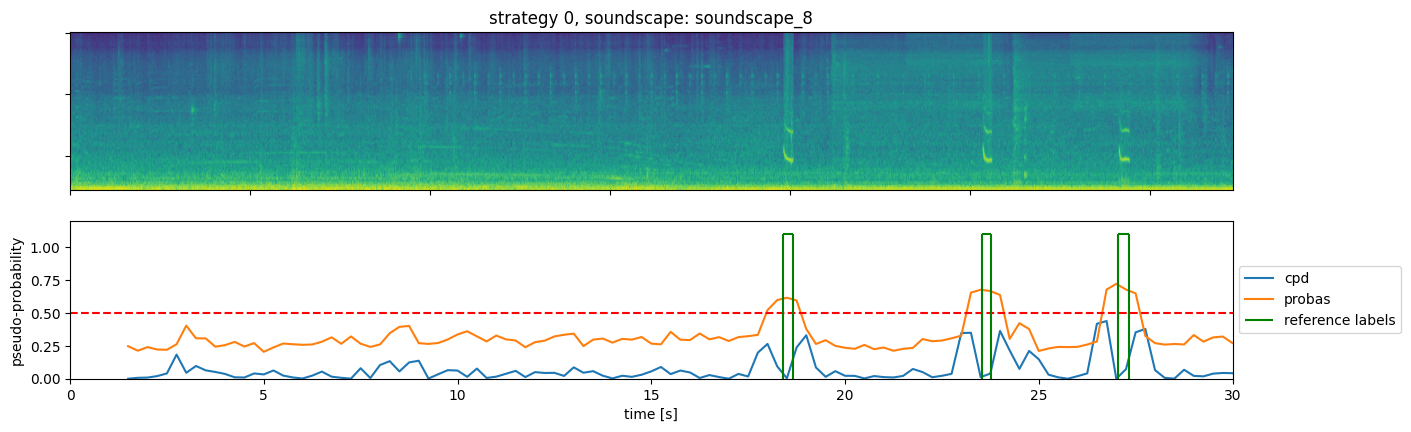

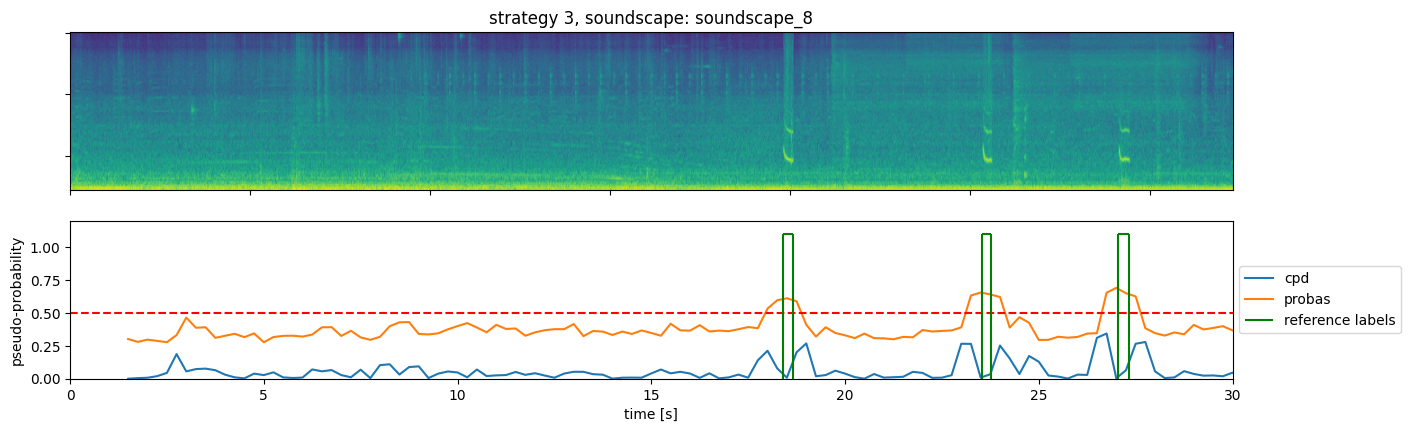

In [113]:
# visualize resulting model on test data
#snr = '0.0'
query_strategy_0.base_dir = test_base_dir
query_strategy_1.base_dir = test_base_dir
query_strategy_2.base_dir = test_base_dir
query_strategy_3.base_dir = test_base_dir
all_test_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]

soundscape_basename = all_test_soundscape_basenames[8]

visualize.visualize_query_strategy(query_strategy_0, "strategy 0", soundscape_basename, test_base_dir, n_queries=n_queries, vis_queries=False)

pos_pred = query_strategy_0.predict_pos_events(test_base_dir, soundscape_basename)
ref_pred = datasets.load_pos_ref_aux(test_base_dir, soundscape_basename)
print("s0: ", metrics.f1_score_from_events(ref_pred, pos_pred, min_iou=0.000001))

visualize.visualize_query_strategy(query_strategy_3, "strategy 3", soundscape_basename, test_base_dir, n_queries=n_queries, vis_queries=False)

pos_pred = query_strategy_3.predict_pos_events(test_base_dir, soundscape_basename)
ref_pred = datasets.load_pos_ref_aux(test_base_dir, soundscape_basename)
print("s1: ", metrics.f1_score_from_events(ref_pred, pos_pred, min_iou=0.000001))

In [61]:
# TODO: maybe I need a better measure of label-quality, the measure needs to be soft
# without any matching. This measure may miss the important differences.
print("Fix  queries, f1 = {:.3f}, miou = {:.3f}".format(fix_f1_means[0], fix_iou_means[0]))
print("AL   queries, f1 = {:.3f}, miou = {:.3f}".format(al_f1_means[0], al_iou_means[0]))
print("Opt. queries, f1 = {:.3f}, miou = {:.3f}".format(1.0, 1.0))

Fix  queries, f1 = 0.850, miou = 0.035
AL   queries, f1 = 0.898, miou = 0.050
Opt. queries, f1 = 1.000, miou = 1.000


Text(0.5, 0, 'number of queries per soundscape')

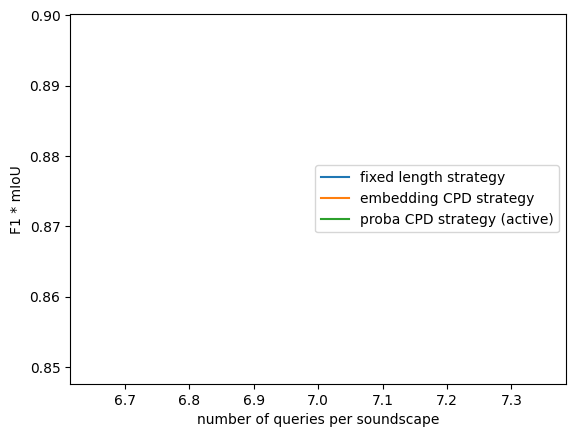

In [18]:
plt.plot(n_queriess, fix_means, label='fixed length strategy')
plt.plot(n_queriess, cp_means, label='embedding CPD strategy')
#plt.plot(n_queriess, al_means_fix, label='proba CPD strategy (passive)')
plt.plot(n_queriess, al_means, label='proba CPD strategy (active)')
plt.legend()
plt.ylabel('F1 * mIoU')
plt.xlabel('number of queries per soundscape')

In [78]:
def annotator_cost(start_time, end_time, cost_linear, cost_overhead):
    segment_cost = (end_time - start_time) * cost_linear + cost_overhead
    return segment_cost

def cost_of_queries(queries, cost_linear, cost_overhead):
    cost = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in queries])
    return cost

# def pos_events_from_queries(queries, oracle, soundscape_basename):
#     pos_events = []
#     for (q_st, q_et) in queries:
#         c = oracle.query(q_st, q_et, soundscape_basename)
#         if c == 1:
#             pos_events.append((q_st, q_et))
#     return pos_events

base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = datasets.load_pos_ref(ref_path)
me1_neg_ref = datasets.load_neg_ref(ref_path, 30)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)
min_iou = 0.0

annotations = me1_pos_ref + me1_neg_ref
annotations = sorted(annotations, key=lambda x: x[0])
annotations = qs.load_query_ref(ref_path, soundscape_length=30)
#annotations = [(0, annotations[0][0])] + annotations
adp_queries = []

min_query_length = 1
max_query_length = 60

idx_ann = 0
end_time = annotations[-1][1]
create_query = True
while create_query:
    (ann_start_time, ann_end_time) = annotations[idx_ann]
    l = ann_end_time - ann_start_time
    
    if l < min_query_length:
        query_start_time = ann_start_time
        query_end_time = query_start_time + min_query_length
        q = (query_start_time, query_end_time)

        if query_end_time > end_time:
            pop = False
            create_query = False
        else:
            pop = True
        adp_queries.append(q)

        while pop:
            ann_end_time = annotations[idx_ann][1]
            if ann_end_time < query_end_time:
                idx_ann += 1
            else:
                pop = False
    else:
        q = (ann_start_time, ann_end_time)
        adp_queries.append(q)
    idx_ann += 1
    if idx_ann >= len(annotations):
        create_query = False
        
# adjust queries    
add_queries = []
for idx_q in range(len(adp_queries)-1):
    q1 = adp_queries[idx_q]
    q2 = adp_queries[idx_q + 1]

    l = q2[0] - q1[1]
    if l < min_query_length:
        adp_queries[idx_q] = (q1[0], q2[0])
    else:
        q = (q1[1], q2[0])
        add_queries.append(q)

adp_queries = adp_queries + add_queries
adp_queries = sorted(adp_queries, key = lambda x: x[0])

cost_overhead = 10
cost_linear = 1

me1_pos_pred = oracle.pos_events_from_queries(adp_queries, soundscape_basename)
print("f1 score (adaptive) : ", metrics.f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (adaptive) : ", cost_of_queries(adp_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

fix_queries = np.linspace(0, 536, int(536/min_query_length))
fix_queries = list(zip(fix_queries[:-1], fix_queries[1:]))
me1_pos_pred = oracle.pos_events_from_queries(fix_queries, soundscape_basename)
print("f1 score (fixed)    : ", metrics.f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou))
print("cost     (fixed)    : ", cost_of_queries(fix_queries, cost_linear=cost_linear, cost_overhead=cost_overhead))

f1 score (adaptive) :  0.8571428571428571
cost     (adaptive) :  756.097
f1 score (fixed)    :  0.8148148148148148
cost     (fixed)    :  5886.0


# Change-point detection

peaks (cosine distance)       :  [7, 10, 2, 5]
prominences (cosine distance) :  [0.29289321881345254, 0.29289321881345254, 0.22527465152822135, 0.22527465152822135]


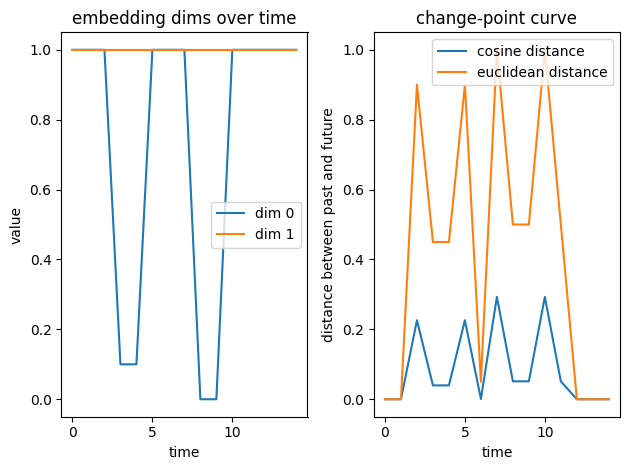

In [79]:
peaks, prominences = cpd.test_change_point_detection()

timings:  (59, 2)
embeddings:  (59, 1024)
[7.5, 11.5, 15.5, 20.0, 26.5]


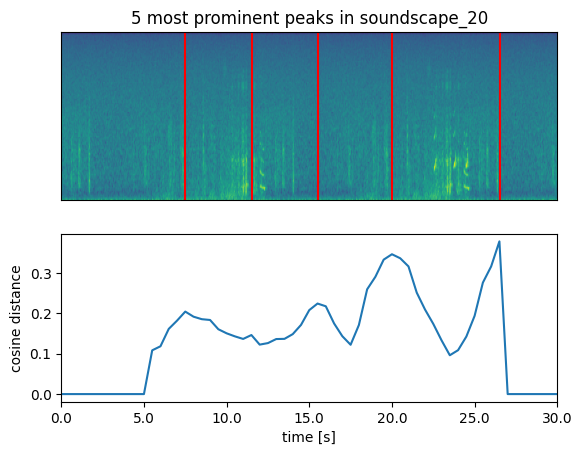

In [80]:
base_dir = '/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_soundscapes_snr_10.0/'
soundscape_basename = 'soundscape_20'
embedding_path = os.path.join(base_dir, '{}.birdnet.embeddings.txt'.format(soundscape_basename))

timings_and_embeddings = datasets.load_timings_and_embeddings(
    file_path=embedding_path,
    embedding_dim=1024
)

timings    = np.array([[s, e] for (s, e, _) in timings_and_embeddings])
embeddings = np.array([r for (_, _, r) in timings_and_embeddings])
print("timings: ", timings.shape)
print("embeddings: ", embeddings.shape)

M = 3
n_peaks = 5
peaks, ds = cpd.change_point_detection_from_embeddings(
    embeddings,
    timings,
    M = M,
    prominence = 0,
    n_peaks = n_peaks,
)

emb_window_length = 3.0
emb_hop_length = 0.5

# align in time
time_align = int(np.ceil((emb_window_length / 2) / emb_hop_length))
time_aligned_ds = np.concatenate((np.zeros(time_align), ds[:-1]))

# extract Mel spectrogram
wave, sr = librosa.load(os.path.join(base_dir, soundscape_basename + ".wav"))
window_length = 0.025
n_fft = utils.next_power_of_2(int(sr * window_length))
mel_spectrogram = librosa.feature.melspectrogram(
    y=wave,
    sr=sr,
    n_fft = n_fft,
    hop_length = n_fft // 2,
)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(np.flip(np.log(mel_spectrogram + 1e-10), axis=0), aspect='auto')
ax[0].set_title("{} most prominent peaks in {}".format(n_peaks, soundscape_basename))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].plot(time_aligned_ds, label='prediction')
ax[1].set_xlim(0, len(time_aligned_ds)-1)
ax[1].set_ylabel('cosine distance')
ax[1].set_xlabel('time [s]')

xticks = ax[1].get_xticks()
xtickslabels = np.linspace(0, 30, len(xticks))
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtickslabels)

N = mel_spectrogram.shape[1]
dt = 30 / N

print(peaks)
peak_frame_indices = [int(c / dt) for c in peaks]

for peak_frame_idx in peak_frame_indices:
    ax[0].axvline(peak_frame_idx, color='red')

In [90]:
soundscape_basename = 'soundscape_16'
soundscape_length = qs.get_soundscape_length(base_dir, soundscape_basename)
opt_queries = qs.optimal_query_strategy(base_dir, soundscape_basename, soundscape_length)
print(opt_queries)

[(0, 2.261777842309625), (2.261777842309625, 2.391777842309625), (2.391777842309625, 10.461136225085408), (10.461136225085408, 10.565136225085407), (10.484513092515307, 10.70353392584864), (10.565136225085407, 10.484513092515307), (10.70353392584864, 30.0)]


In [94]:
ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
pos_ref = datasets.load_pos_ref(ref_path)
pos_ref

[(2.261777842309625, 2.391777842309625),
 (10.461136225085408, 10.565136225085407),
 (10.484513092515307, 10.70353392584864)]

In [111]:
ls = np.concatenate(cp_lengths)
print("mean: ", np.mean(ls))
print("median: ", np.median(ls))
print("min: ", np.min(ls))
print("max: ", np.max(ls))
#print(np.sum(ls < 2))

mean:  7.009345794392523
median:  6.0
min:  2.0
max:  23.0


# Real soundscape

In [73]:
base_dir = '../soundscapes/ME/train/'
soundscape_basename = 'ME2'
xs = np.arange(1, 200, 10)
fix_ys = []
cp_ys = []
for idx, n_queries in tqdm.tqdm(enumerate(xs)):
    soundscape_length = qs.get_soundscape_length(base_dir, soundscape_basename)
    name_to_label_quality, n_opt_queries = evaluate.evaluate_all(base_dir, soundscape_basename, min_iou=0.01, n_queries=n_queries)
    fix_ys.append(name_to_label_quality['fix'])
    cp_ys.append(name_to_label_quality['cp'])

20it [00:09,  2.06it/s]


Text(0.5, 0, 'budget')

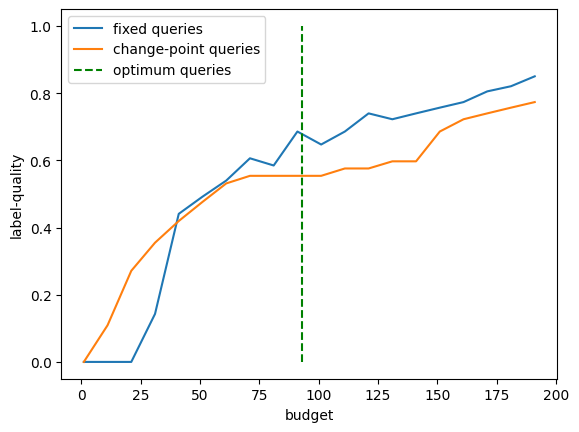

In [74]:
plt.plot(xs, fix_ys, label='fixed queries')
plt.plot(xs, cp_ys, label='change-point queries')
plt.vlines([n_opt_queries], ymin=0, ymax=1, color='green', linestyle='dashed', label='optimum queries')
plt.legend()
plt.ylabel('label-quality')
plt.xlabel('budget')

# OLD CODE

In [46]:
base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = load_annotations(ref_path)
me1_neg_ref = compute_neg_ref(me1_pos_ref)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)


file_end_time = me1_pos_ref[-1][1]

n_segment_lengths = 50
min_segment_length = 1
max_segment_length = 30
segment_lengths = np.linspace(min_segment_length, max_segment_length, n_segment_lengths)

n_cost_overheads = 50
min_cost_overhead = 0
max_cost_overhead = 20
cost_overheads = np.linspace(min_cost_overhead, max_cost_overhead, n_cost_overheads)

# label_quality_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))
# cost_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_fixed = np.zeros((n_segment_lengths, n_cost_overheads))
cost_fixed = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_oracle = np.zeros((n_segment_lengths, n_cost_overheads))
cost_oracle = np.zeros((n_segment_lengths, n_cost_overheads))


cost_linear = 1
min_iou = 0.01 #0.025 * 3

#segment_lengths = [1.0]
#cost_overheads = [100.0]

for idx_seg, segment_length in enumerate(segment_lengths):
    for idx_cost, cost_overhead in enumerate(cost_overheads):

        # ORACLE: compute cost of optimal query strategy (recovers true labels using weak-labels)
        cost_opt_query_pos = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_pos_ref])
        cost_opt_query_neg = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_neg_ref])
        cost_opt_query = cost_opt_query_neg + cost_opt_query_pos
        f1_opt = f1_score_from_events(me1_pos_ref, me1_pos_ref, min_iou=min_iou)

        # FIXED: compute cost of segment query strategy
        time_counter = 0.0
        cost_fix_query = 0.0
        me1_pos_pred = []
        
        # simulate annotation of the whole file
        while time_counter < file_end_time:
            query_start_time = time_counter
            query_end_time   = time_counter + (segment_length)
    
            # get annotation
            c = oracle.query(query_start_time, query_end_time, soundscape_basename)
            if c == 1:
                me1_pos_pred.append((query_start_time, query_end_time))
    
            # get cost
            cost = annotator_cost(query_start_time, query_end_time, cost_linear, cost_overhead)
            cost_fix_query += cost
    
            # increase time counter
            time_counter += segment_length

        f1 = f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou)

        # baseline
        label_quality_fixed[idx_seg, idx_cost] = f1
        cost_fixed[idx_seg, idx_cost] = cost_fix_query

        # oracle
        label_quality_oracle[idx_seg, idx_cost] = f1_opt
        cost_oracle[idx_seg, idx_cost] = cost_opt_query

        # bounded-oracle

(50, 50)
(50, 50)
0.43915399422756474


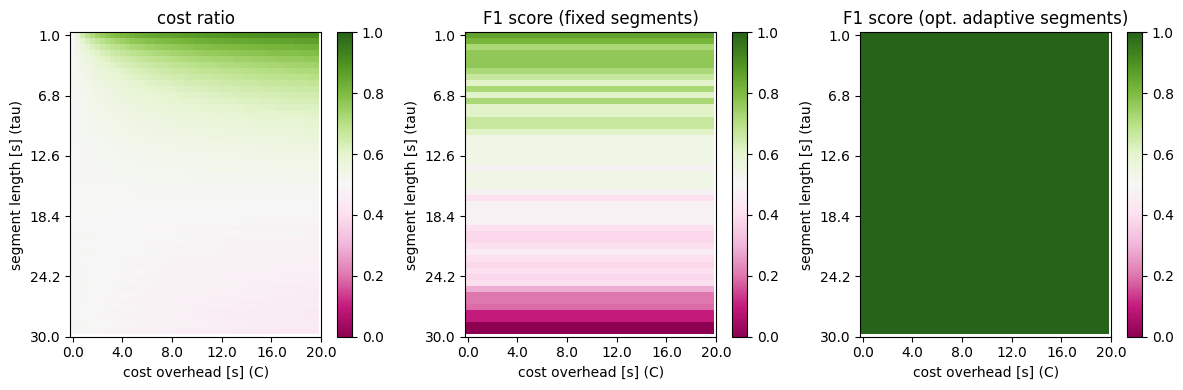

In [49]:
cost_ratio_result = cost_fixed / (cost_fixed + cost_oracle)
label_quality_ratio_result = label_quality_fixed #1 / (1 + label_quality_fixed)
print(label_quality_ratio_result.shape)
print(cost_ratio_result.shape)


cmap = matplotlib.colormaps['PiYG']

fig, ax = plt.subplots(1,3, figsize=(12,4))

img0 = ax[0].imshow(cost_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[0].set_title('cost ratio')
plt.colorbar(img0, ax=ax[0])

img1 = ax[1].imshow(label_quality_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[1].set_title('F1 score (fixed segments)')
plt.colorbar(img1, ax=ax[1])


img2 = ax[2].imshow(label_quality_oracle, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[2].set_title('F1 score (opt. adaptive segments)')
plt.colorbar(img2, ax=ax[2])

for idx in [0, 1, 2]:
    # set xticks
    xticks = ax[idx].get_xticks()[1:]
    #print(xticks)
    xticklabels = np.linspace(min_cost_overhead, max_cost_overhead, len(xticks))
    xticklabels = ['{:.1f}'.format(c) for c in xticklabels]
    #print(xticklabels)
    ax[idx].set_xticks(xticks)
    ax[idx].set_xticklabels(xticklabels)
    ax[idx].set_xlabel('cost overhead [s] (C)')
    
    # set yticks
    yticks = ax[idx].get_yticks()[1:]
    #print("y: ", yticks)
    yticklabels = np.linspace(min_segment_length, max_segment_length, len(yticks))
    yticklabels = ['{:.1f}'.format(c) for c in yticklabels]
    #print("yticklabels: ", yticklabels)
    ax[idx].set_yticks(yticks)
    ax[idx].set_yticklabels(yticklabels)
    ax[idx].set_ylabel('segment length [s] (tau)')

plt.tight_layout()
print(np.min(cost_ratio_result))

(2, 2)


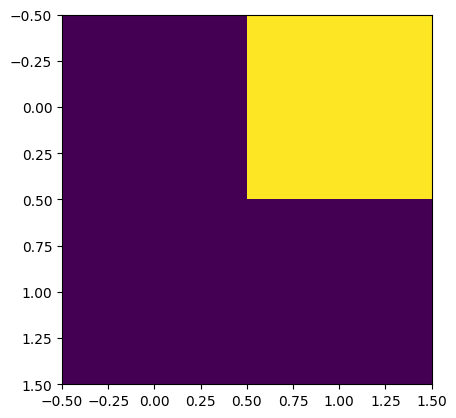

In [33]:
x = np.array([
    [0, 1],
    [0, 0]
])
print(x.shape)
plt.imshow(x)

In [8]:
# measure of label quality

# Baseline: fixed segment lengths
# simulate weak-labelling approach with fixed length segments
# 1. true label
# 2. sliding window with max

# compute cost of fixed length segment approach
# Oracle: optimal adaptive segment lengths
# compute cost of optimal adaptive segments approach

# Human: simulate sub-optimal adaptive segments approach, taking human characteristics into account
# 1. set minimum and maximum segment lengths
# 2. come up with reasonable heuristic
#     a. for all events shorter than min, place window on top of them
#     b. for all events longer than max, distribute window inside
#     c. for all remaining events, place optimal window on them
#     d. derive labels

# simulate annotator quality, if window overlaps too little with event, add label noise

# Figure 1. Label quality on y-axis, annotator cost on x-axis
# Baseline: plot this for different segment lengths, varying between minimum event length to maximum event length
# Oracle: plot this optimal point in figure. This is the least amount of annotation necessary (under the assumed cost model) to derive optimal labels.
# Human: plot this sub-optimal point in figure. This is approximately the least amount of annotation necessary to derive the sub-optimal labels.
#
# The idea of figure 1 is to convince the reader that the persuit of adaptive segmentation lengths can have benefits, 
# and to understand better under which scenarios it will have benefits. I think this is important.

# Things to vary.
#
# Annotator model. Different assumptions on label noise for sub-optimal overlap with event of interest.
# Cost model. Different assumptions on the constant overhead cost and the gradient for the linear cost.